In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

## Player Types:

- `default`: An AI agent initialized with a zero-shot prompt. Just the gave description.
- `spp`: Solo Performance Prompting; an AI agent initialized with the SPP prompt.
- `cot`: Chain-of-Thought; an AI agent initialized with the COT prompt.
- `srep`: Singe-Round-Equilibrium-Player; a player who strictly follows the Single Round Equilibrium Strategy (a specific probability distribution over the available moves)
- `pp`: Pattern Player; Follows a cyclic pattern of moves. Always playes moves from this pattern.
- `ap`: Adaptive Player; finds the most frequent move their opponent plays and counters it.
- `tft`: Tit-for-Tat Player; counters opponent's last played move.

## ToT experiments:

- We compare an AI agent in a ToT environment vs all other agents. If the opponent is also an AI agent, then the opponent in **NOT** a ToT player.
- ToT: Each time the AI agent has to play. They generate 5 different answers. We then choose the most frequent result and choose an answer that gave that result. We continue with this history for the rest of the game (as many rounds as it is). Conficts are resolved at random and/or by choosing the first answer that gave the result we picked.

In [2]:
def plot_average_results(
    player_type: str,
    log_dir: str,
    model_name: str,
    game_type: str,
    game_settings_type: str,
    ax: plt.Axes,
    iteration_cnt : int,
):
    # Structure to collect data per opponent type
    data = defaultdict(lambda: {'win': [], 'loss': [], 'tie': []})

    opponent_types = list()

    for itr in range(iteration_cnt):
        directory = os.path.join(log_dir, f"iteration_{itr}", model_name, game_type, game_settings_type)

        if not os.path.isdir(directory):
            continue

        for dir in sorted(
            os.listdir(directory),
            key=lambda x: int(x.split('_')[-1])
        ):
            info_path = os.path.join(directory, dir, 'game.json')
            if not os.path.isfile(info_path):
                continue

            with open(info_path) as f:
                info = json.load(f)

            player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
            if player_type not in player_types:
                continue

            player_idx = player_types.index(player_type)
            opponent_type = player_types[1 - player_idx]

            if opponent_type not in opponent_types:
                opponent_types.append(opponent_type)

            rates = info.get(f"player_{player_idx}_rates", {})
            for key in ['win', 'loss', 'tie']:
                data[opponent_type][key].append(rates.get(key, 0))

    # Consistent ordering of opponent types
    n_opponents = len(opponent_types)
    x = np.arange(n_opponents)
    total_bar_width = 0.8
    bar_width = total_bar_width / iteration_cnt

    # Plot bars for each iteration
    for i in range(iteration_cnt):
        wins = [data[opp]['win'][i] if i < len(data[opp]['win']) else 0 for opp in opponent_types]
        losses = [data[opp]['loss'][i] if i < len(data[opp]['loss']) else 0 for opp in opponent_types]
        ties = [data[opp]['tie'][i] if i < len(data[opp]['tie']) else 0 for opp in opponent_types]

        offsets = x - total_bar_width/2 + i * bar_width

        # Only add legend labels in first iteration
        win_label = 'win' if i == 0 else ""
        loss_label = 'loss' if i == 0 else ""
        tie_label = 'tie' if i == 0 else ""

        ax.bar(offsets, wins, bar_width, label=win_label, color='tab:blue')
        ax.bar(offsets, losses, bar_width, bottom=wins, label=loss_label, color='tab:orange')
        tie_bottom = [w + l for w, l in zip(wins, losses)]
        ax.bar(offsets, ties, bar_width, bottom=tie_bottom, label=tie_label, color='tab:green')

    ax.set_title(
        f"Performance of \"{player_type}\" against various opponents (30 rounds with each opponent)\n"
        f"Model: {model_name}, Game: {game_type}, Settings: {game_settings_type}",
        fontsize=11
    )

    ax.set_xlabel("Opponent player type", fontsize=10)
    ax.set_ylabel("Outcome rate (win/loss/tie)", fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(opponent_types, rotation=45, ha='right')
    
    ax.legend(title="Game result", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=10)

    ax.text(
        1.0, -0.15,
        f"Each group shows {iteration_cnt} runs per opponent",
        transform=ax.transAxes,
        fontsize=8,
        ha='right'
    )



In [ ]:
def plot_average_results_of_group(player_type : str, log_source : str, iteration_cnt : int):
    fig, axs = plt.subplots(3, 4, figsize=(32, 16))

    plot_average_results(player_type, log_source, "Llama 3.3 70B Instruct", "rps", "eq1", axs[0, 0], iteration_cnt)
    plot_average_results(player_type, log_source, "Llama 3.3 70B Instruct", "rps", "ba3", axs[0, 1], iteration_cnt)
    plot_average_results(player_type, log_source, "Llama 3.3 70B Instruct", "rps", "eq1-alt", axs[0, 2], iteration_cnt)
    plot_average_results(player_type, log_source, "Llama 3.3 70B Instruct", "rps", "ba3-alt", axs[0, 3], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.5 Sonnet v2", "rps", "eq1", axs[1, 0], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.5 Sonnet v2", "rps", "ba3", axs[1, 1], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.5 Sonnet v2", "rps", "eq1-alt", axs[1, 2], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.5 Sonnet v2", "rps", "ba3-alt", axs[1, 3], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.7 Sonnet", "rps", "eq1", axs[2, 0], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.7 Sonnet", "rps", "ba3", axs[2, 1], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.7 Sonnet", "rps", "eq1-alt", axs[2, 2], iteration_cnt)
    plot_average_results(player_type, log_source, "Claude 3.7 Sonnet", "rps", "ba3-alt", axs[2, 3], iteration_cnt)
    plt.tight_layout()

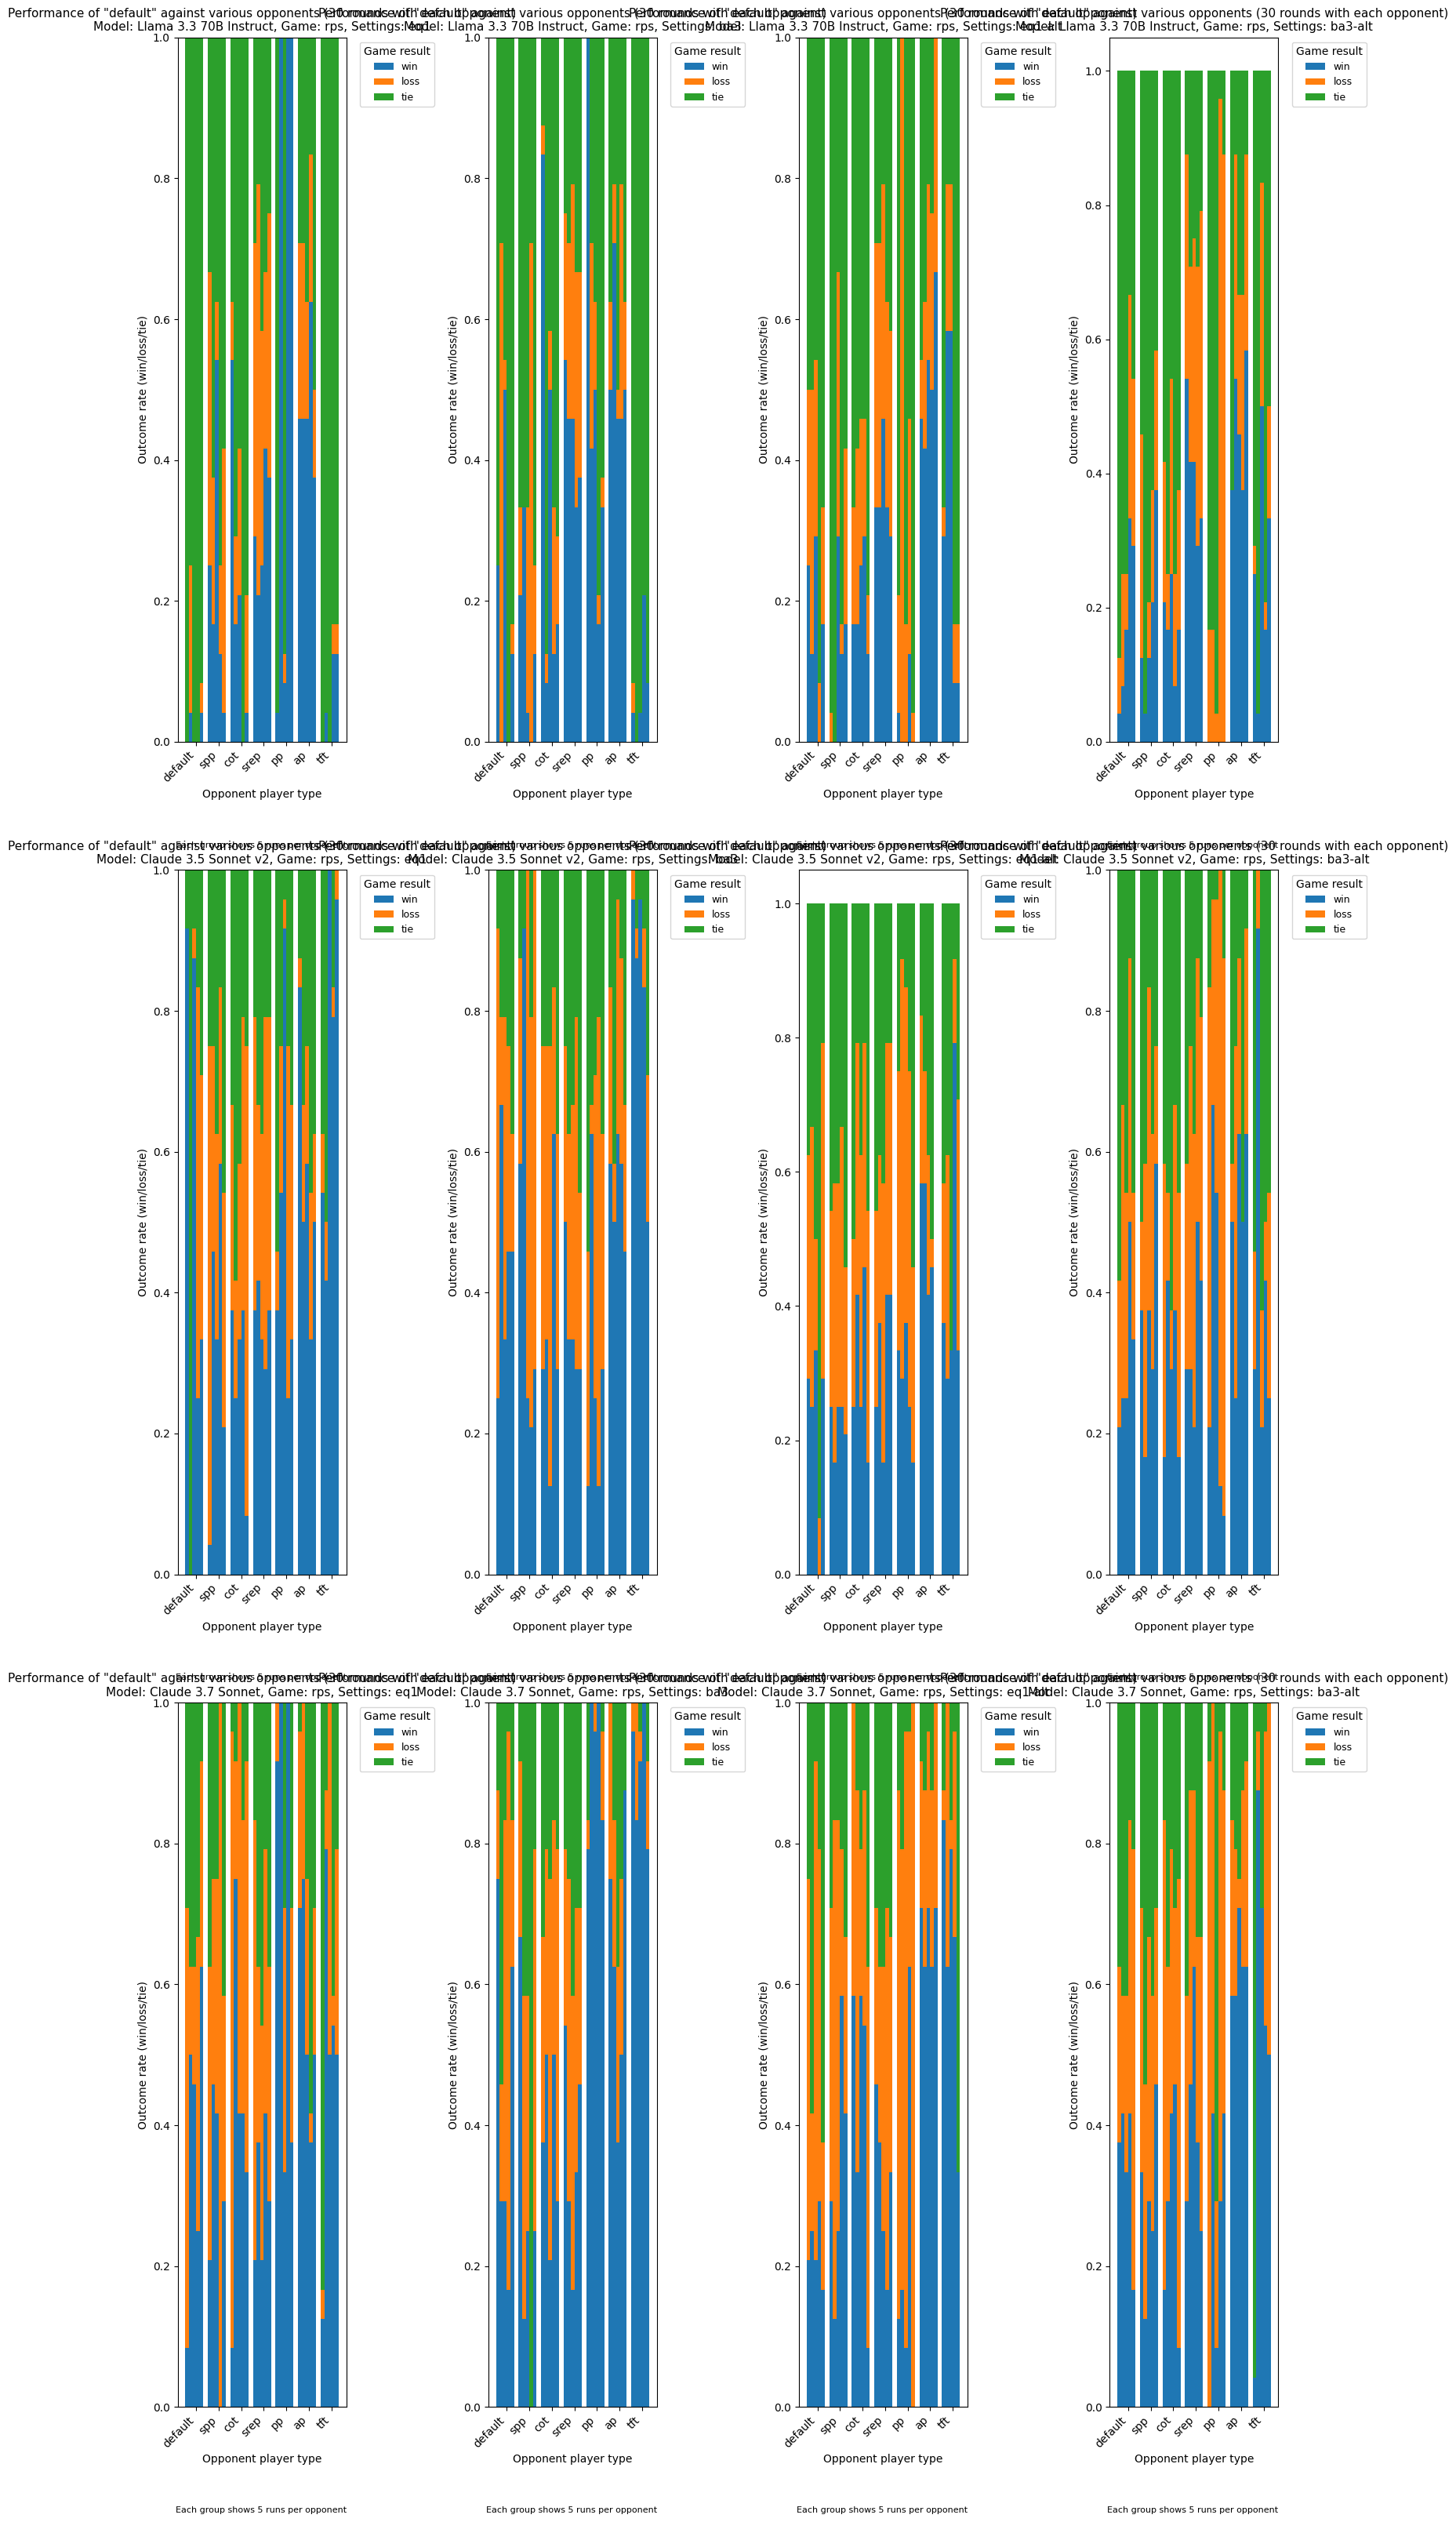

In [6]:
plot_average_results_of_group("default", "data_2", 5)

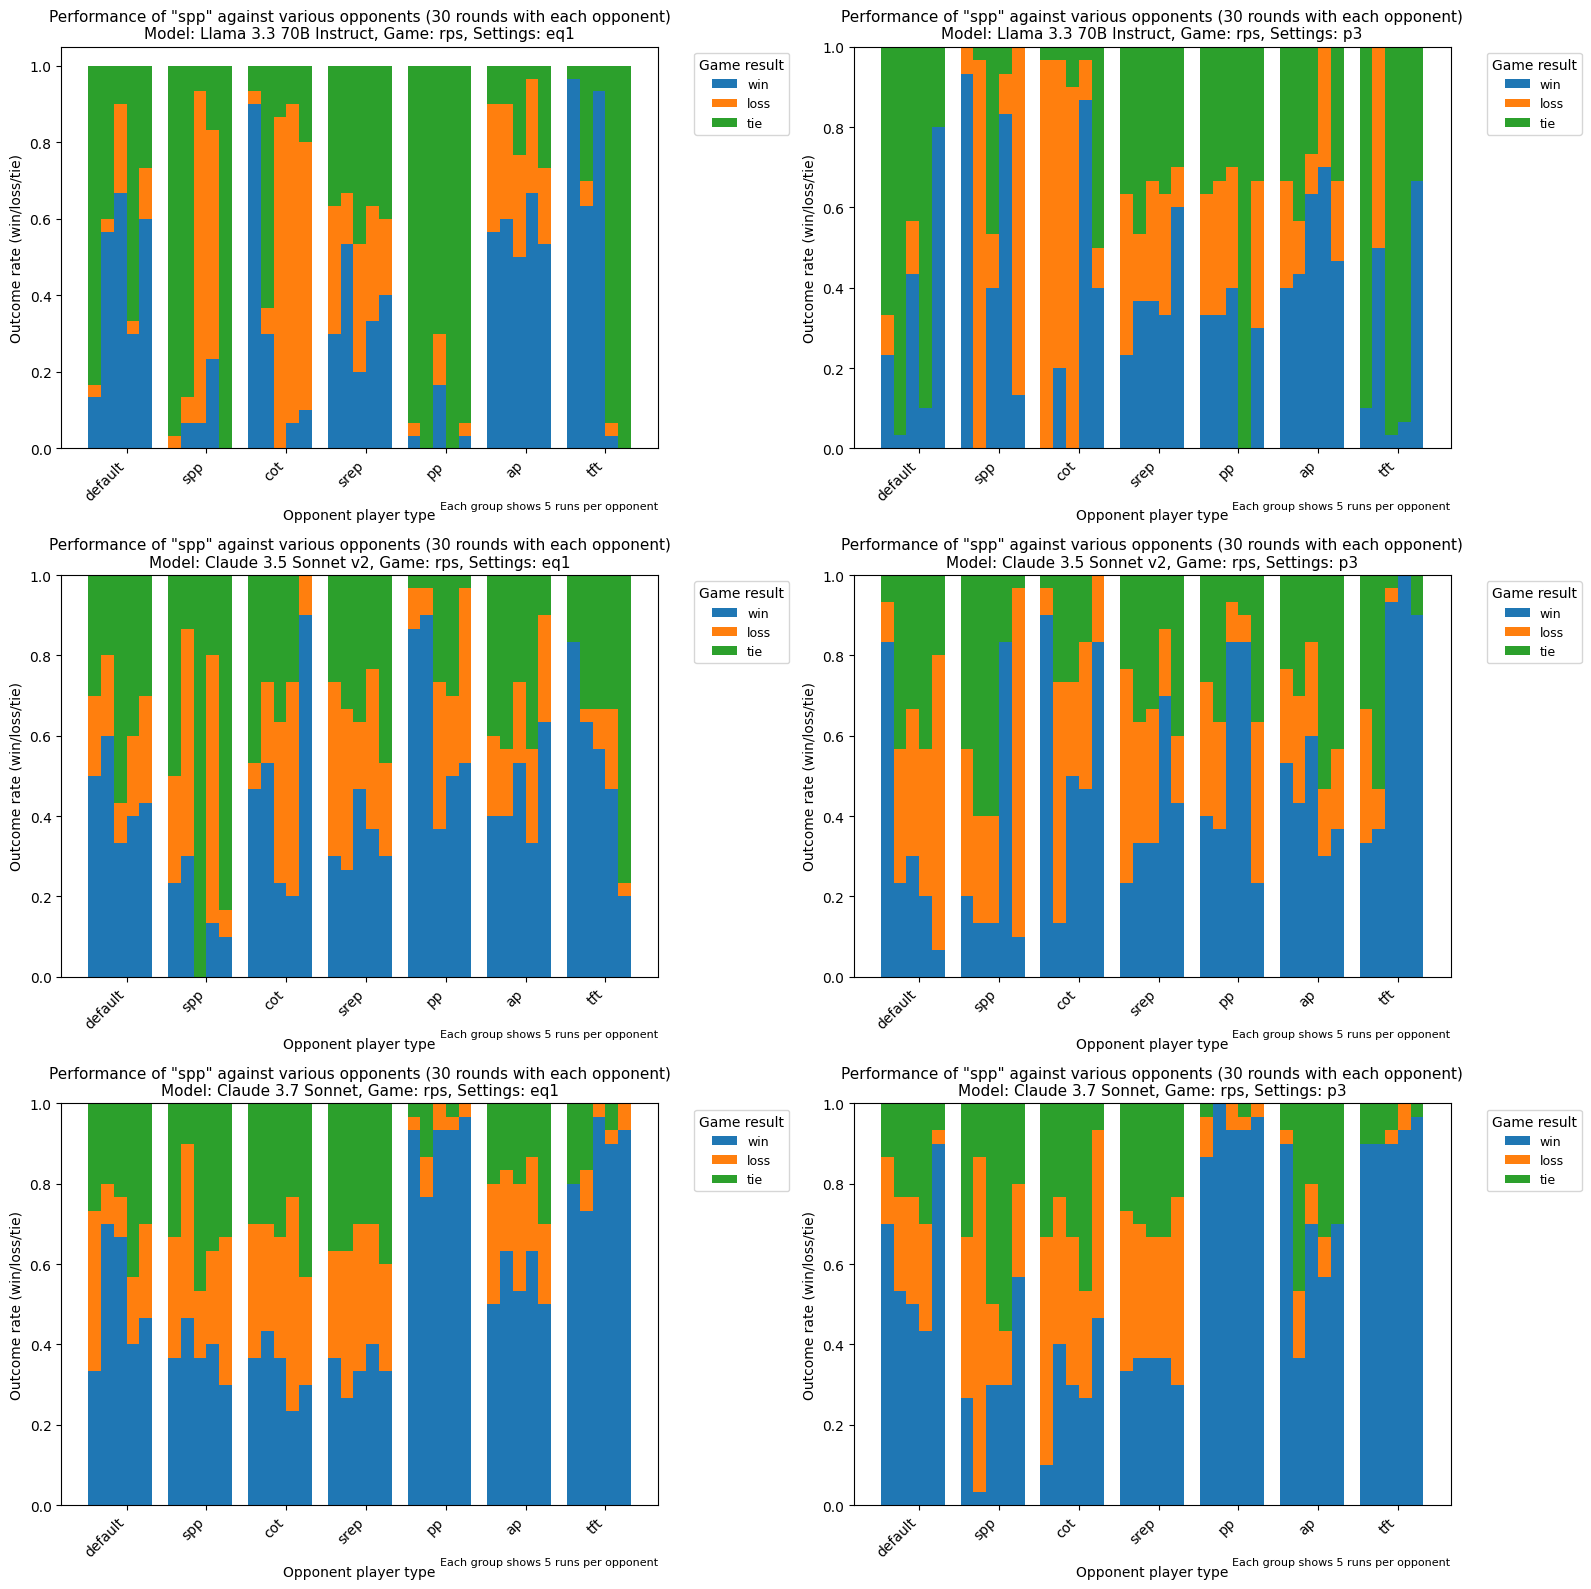

In [5]:
plot_average_results_of_group("spp", "data", 5)

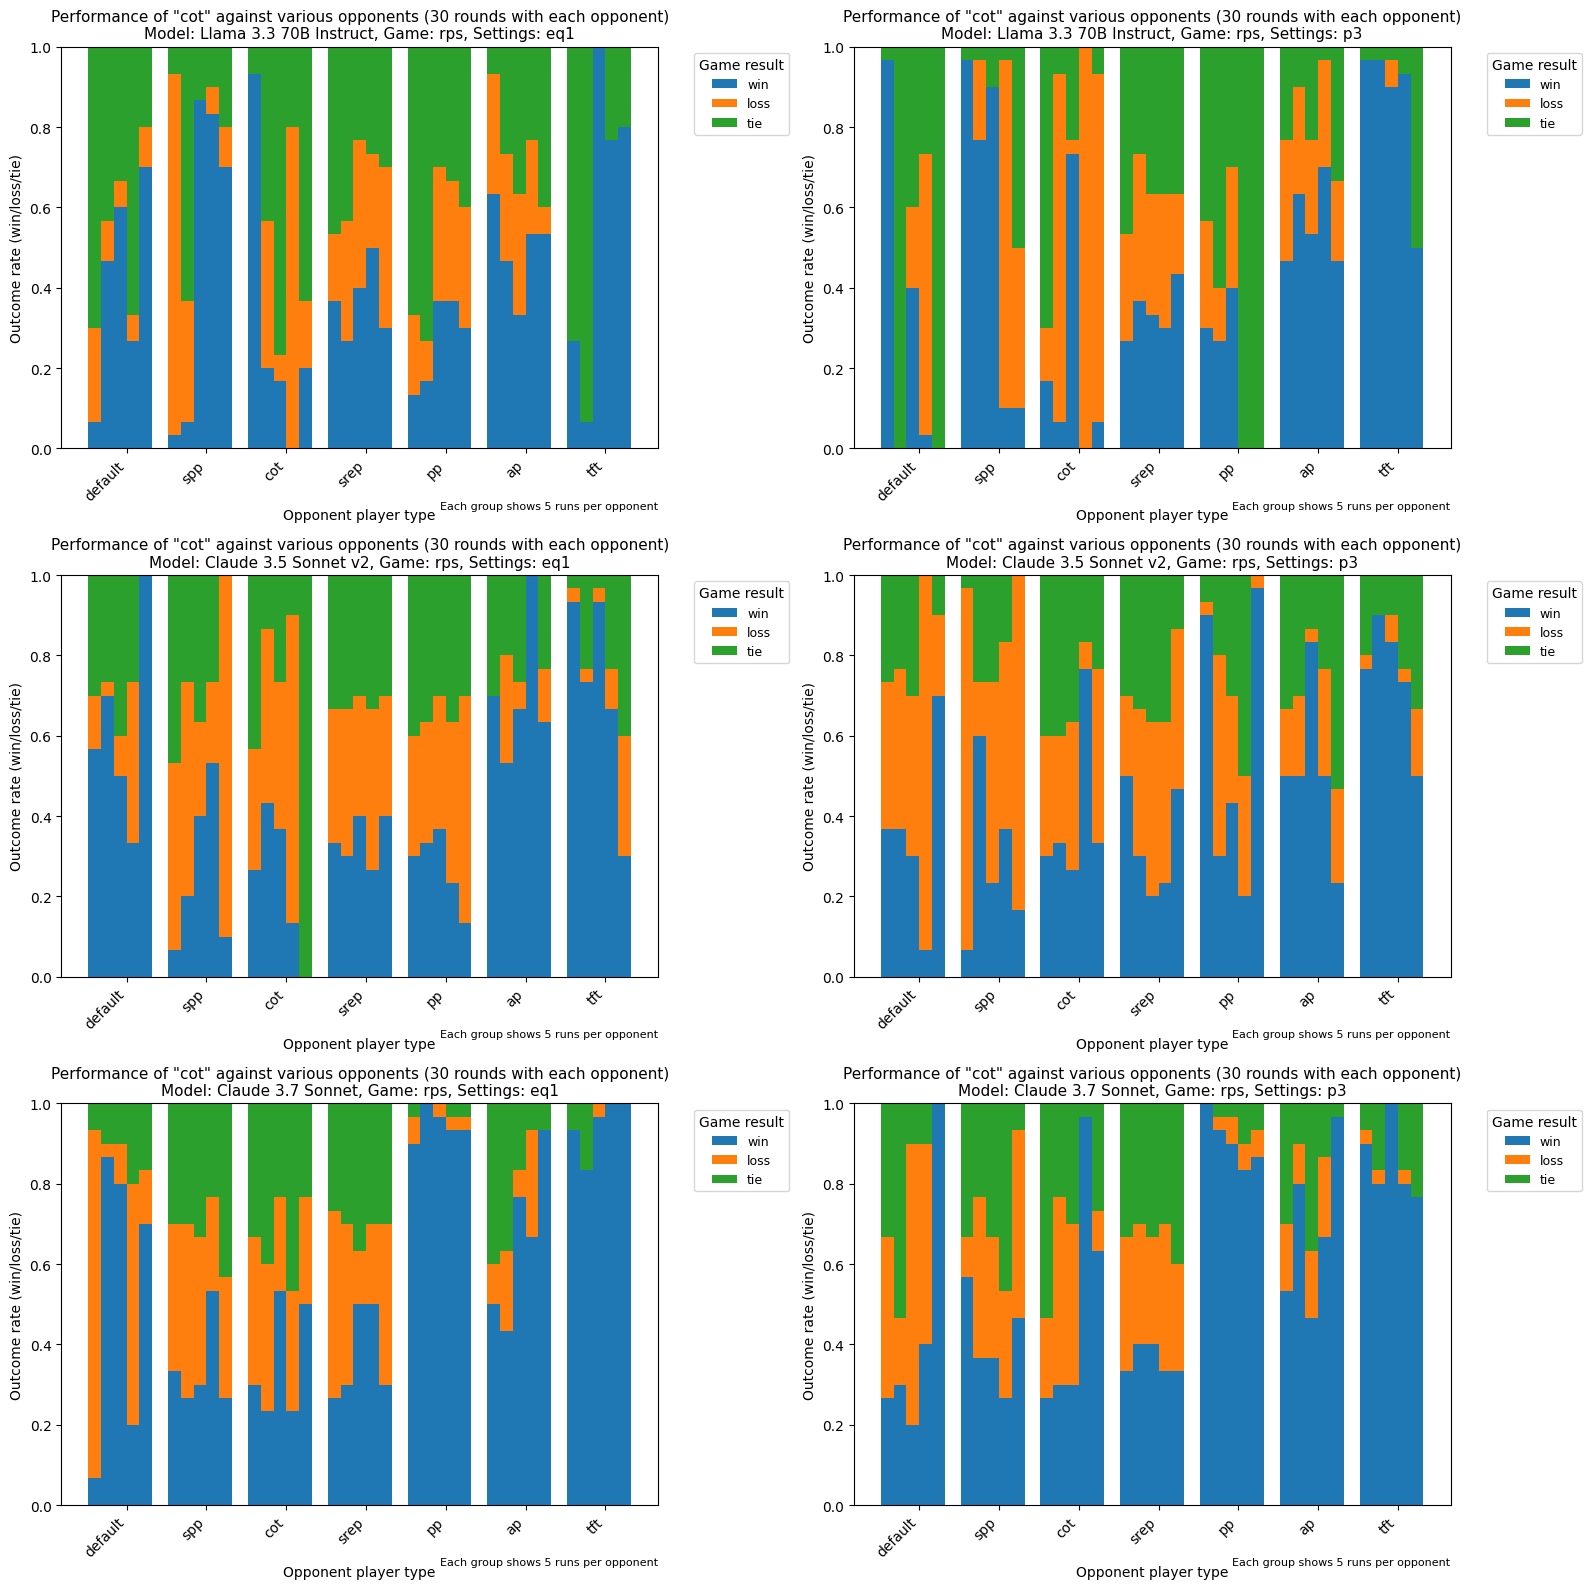

In [6]:
plot_average_results_of_group("cot", "data", 5)

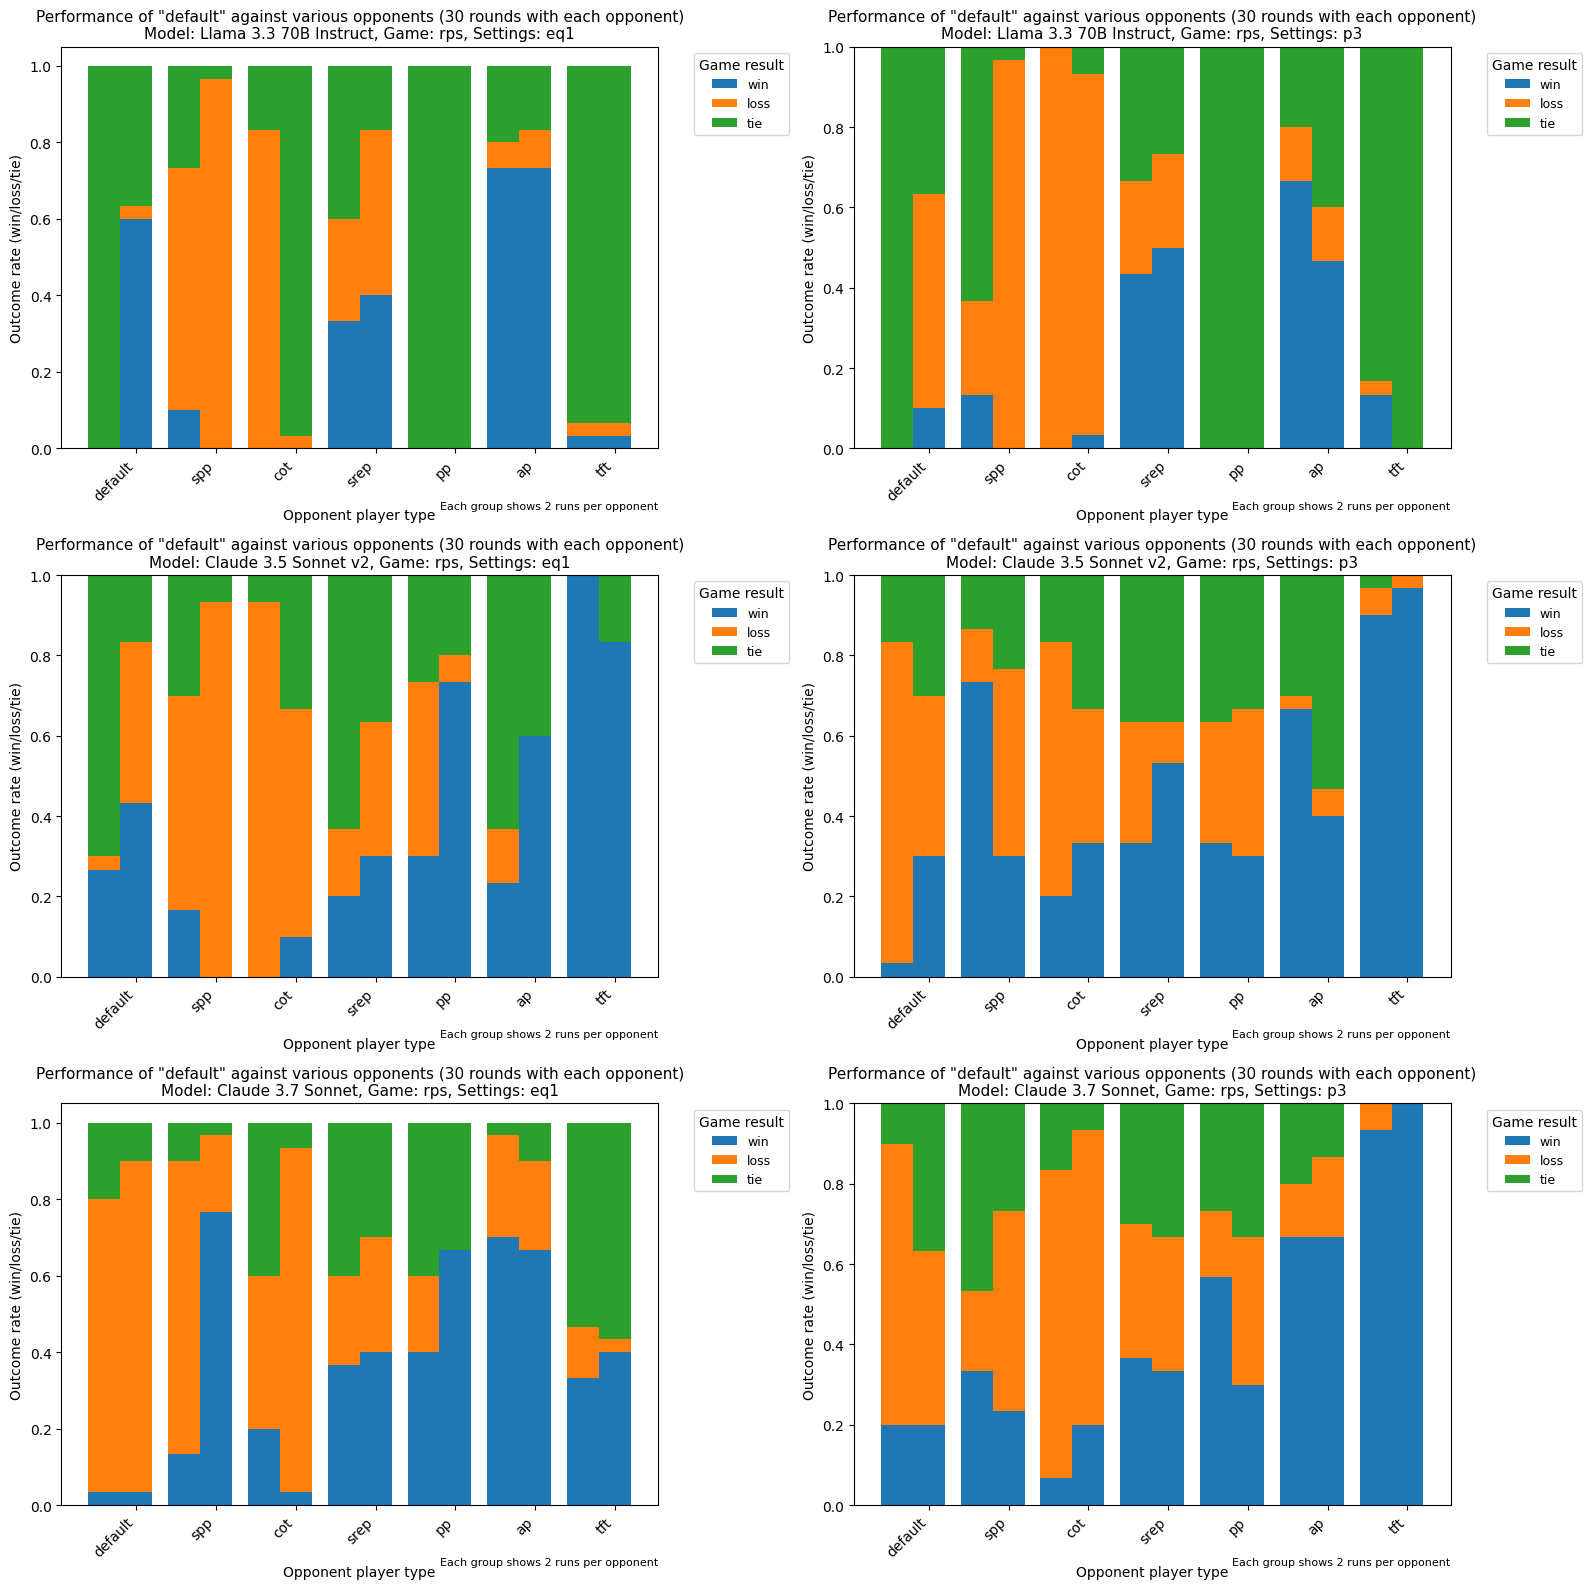

In [7]:
plot_average_results_of_group("default", "data_tot", 2)

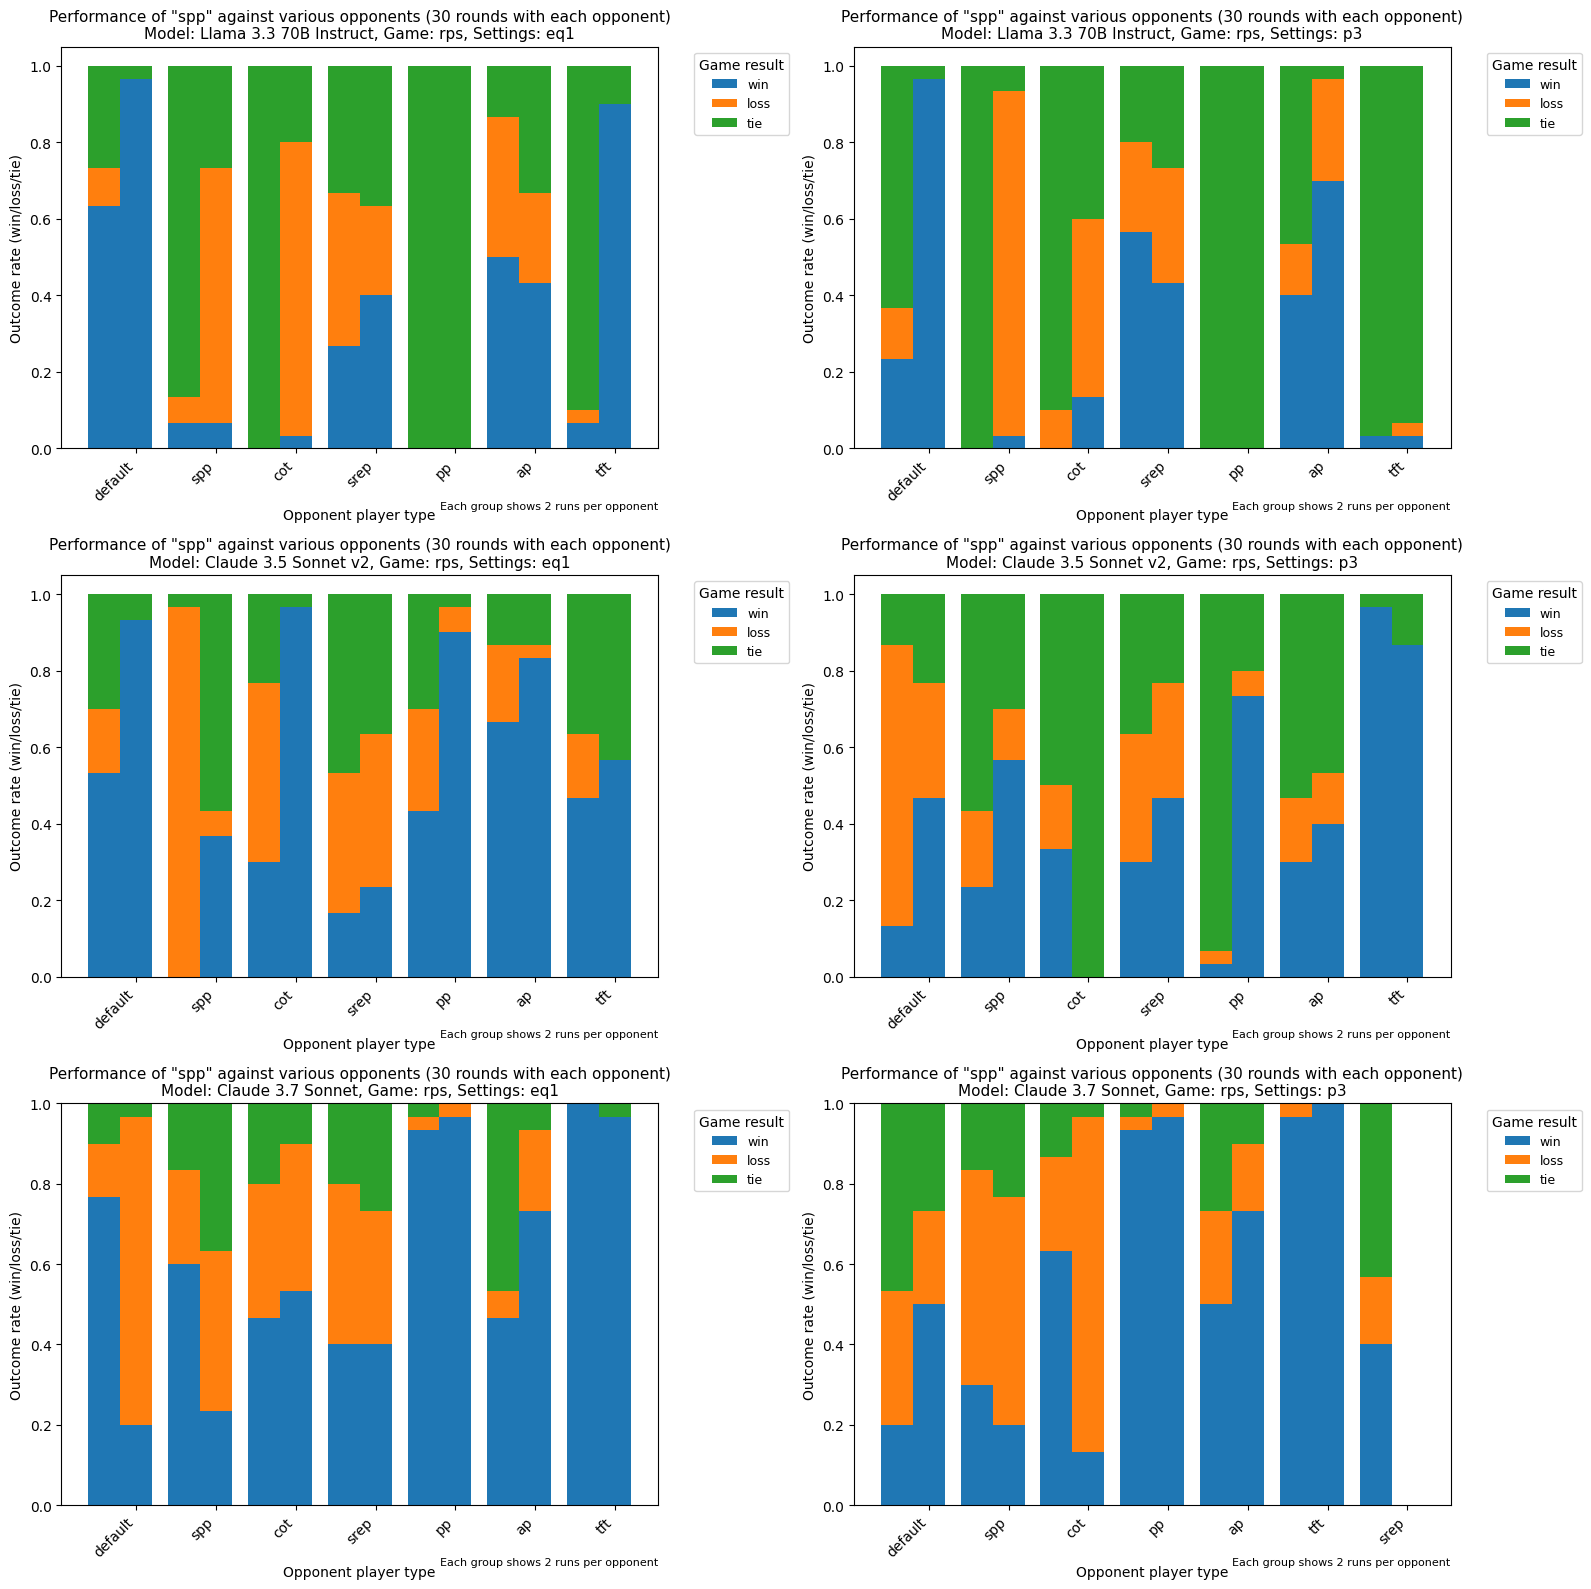

In [8]:
plot_average_results_of_group("spp", "data_tot", 2)

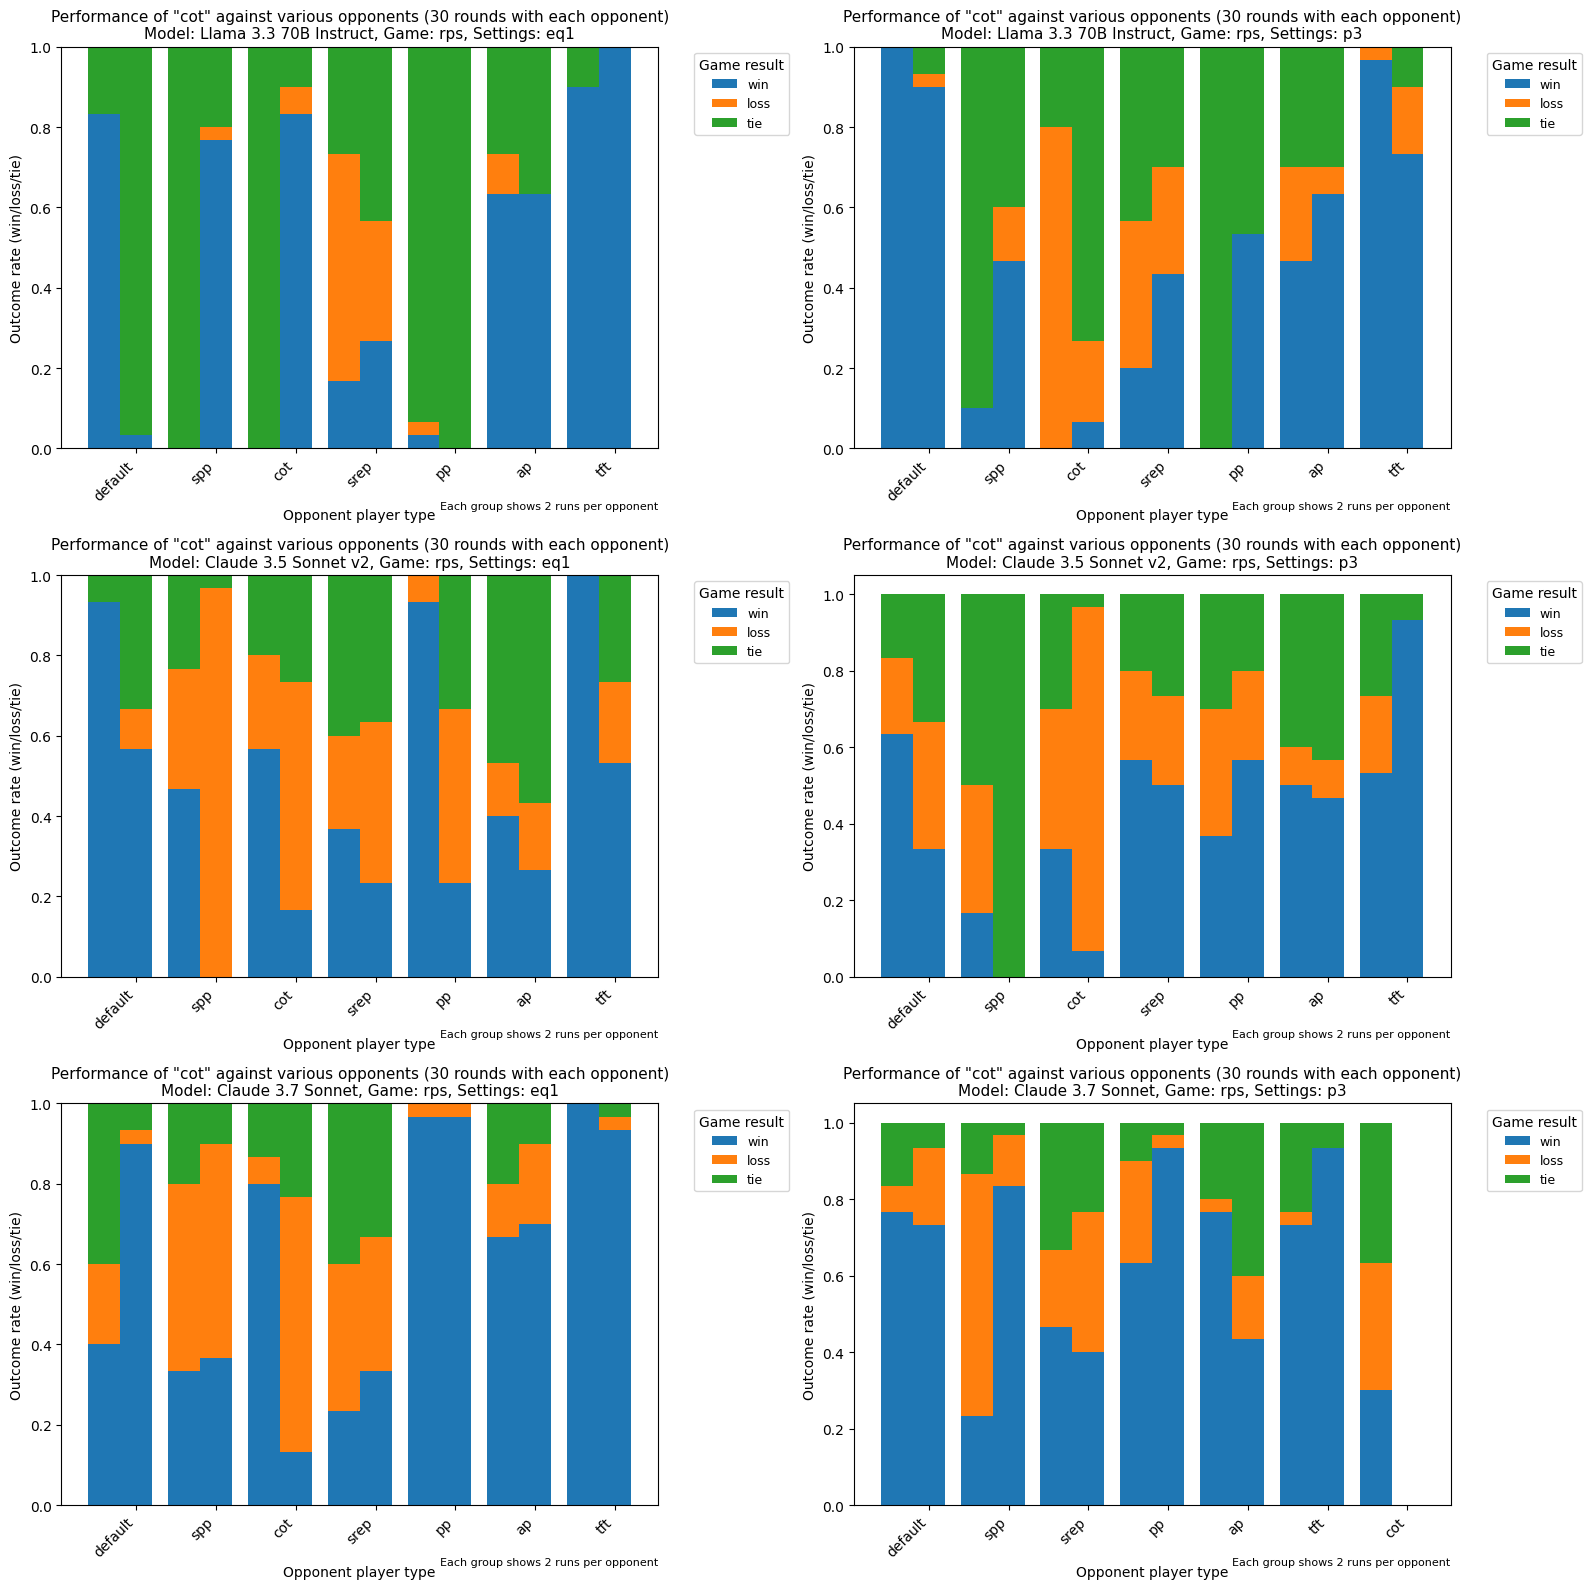

In [9]:
plot_average_results_of_group("cot", "data_tot", 2)

In [10]:
def plot_cumulative_results(
    player_type: str,
    log_dir: str,
    model_name: str,
    game_type: str,
    game_settings_type: str,
    ax: plt.Axes
):
    directory = os.path.join(log_dir, model_name, game_type, game_settings_type)

    # Structure: opponent_type -> {'win': [..], 'loss': [..], 'tie': [..]} (each list of length 6 for 6 segments)
    data = defaultdict(lambda: {'win': [], 'loss': [], 'tie': []})
    opponent_types = []

    for dir in sorted(os.listdir(directory), key=lambda x: int(x.split('_')[-1])):
        info_path = os.path.join(directory, dir, 'game.json')
        if not os.path.isfile(info_path):
            continue

        with open(info_path) as f:
            info = json.load(f)

        player_types = [info.get(f"player_{i}_player_type") for i in range(2)]
        if player_type not in player_types:
            continue

        player_idx = player_types.index(player_type)
        opponent_type = player_types[1 - player_idx]

        if opponent_type not in opponent_types:
            opponent_types.append(opponent_type)

        points = info.get(f"player_{player_idx}_points", [])
        if len(points) == 0:
            continue

        # Collect cumulative outcome rates every 5 rounds
        for i in range(5, len(points) + 1, 5):
            segment = points[:i]
            total = len(segment)

            wins = sum(1 for p in segment if p > 0)
            losses = sum(1 for p in segment if p < 0)
            ties = sum(1 for p in segment if p == 0)

            data[opponent_type]['win'].append(wins / total)
            data[opponent_type]['loss'].append(losses / total)
            data[opponent_type]['tie'].append(ties / total)

    # Number of rounds per opponent
    rounds_per_opponent = 30 // 5 # Assuming 30 rounds total, with segments every 5 rounds
    n_opponents = len(opponent_types)
    x = np.arange(n_opponents)
    total_bar_width = 0.8
    bar_width = total_bar_width / rounds_per_opponent

    # Plot bars for each round segment (like iterations)
    for i in range(rounds_per_opponent):
        wins = [data[opp]['win'][i] if i < len(data[opp]['win']) else 0 for opp in opponent_types]
        losses = [data[opp]['loss'][i] if i < len(data[opp]['loss']) else 0 for opp in opponent_types]
        ties = [data[opp]['tie'][i] if i < len(data[opp]['tie']) else 0 for opp in opponent_types]

        offsets = x - total_bar_width / 2 + i * bar_width

        # Only label the first group with legend entries
        win_label = 'win' if i == 0 else ""
        loss_label = 'loss' if i == 0 else ""
        tie_label = 'tie' if i == 0 else ""

        ax.bar(offsets, wins, bar_width, label=win_label, color='tab:blue')
        ax.bar(offsets, losses, bar_width, bottom=wins, label=loss_label, color='tab:orange')
        tie_bottom = [w + l for w, l in zip(wins, losses)]
        ax.bar(offsets, ties, bar_width, bottom=tie_bottom, label=tie_label, color='tab:green')

    # Axis and legend setup
    ax.set_title(
        f"Performance of \"{player_type}\" against various opponents (cumulative every 5 rounds)\n"
        f"Model: {model_name}, Game: {game_type}, Settings: {game_settings_type}",
        fontsize=11
    )
    ax.set_xlabel("Opponent player type", fontsize=10)
    ax.set_ylabel("Outcome rate (win/loss/tie)", fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(opponent_types, rotation=45, ha='right')

    ax.legend(title="Game result", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=10)

    ax.text(
        1.0, -0.15,
        "Each group shows cumulative results at rounds 5, 10, ..., 30",
        transform=ax.transAxes,
        fontsize=8,
        ha='right'
    )


In [11]:
def plot_cumulative_results_of_group(player_type : str, log_source : str):
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))

    plot_cumulative_results(player_type, log_source, "Llama 3.3 70B Instruct", "rps", "eq1", axs[0, 0])
    plot_cumulative_results(player_type, log_source, "Llama 3.3 70B Instruct", "rps", "p3", axs[0, 1])
    plot_cumulative_results(player_type, log_source, "Claude 3.5 Sonnet v2", "rps", "eq1", axs[1, 0])
    plot_cumulative_results(player_type, log_source, "Claude 3.5 Sonnet v2", "rps", "p3", axs[1, 1])
    plot_cumulative_results(player_type, log_source, "Claude 3.7 Sonnet", "rps", "eq1", axs[2, 0])
    plot_cumulative_results(player_type, log_source, "Claude 3.7 Sonnet", "rps", "p3", axs[2, 1])
    plt.tight_layout()

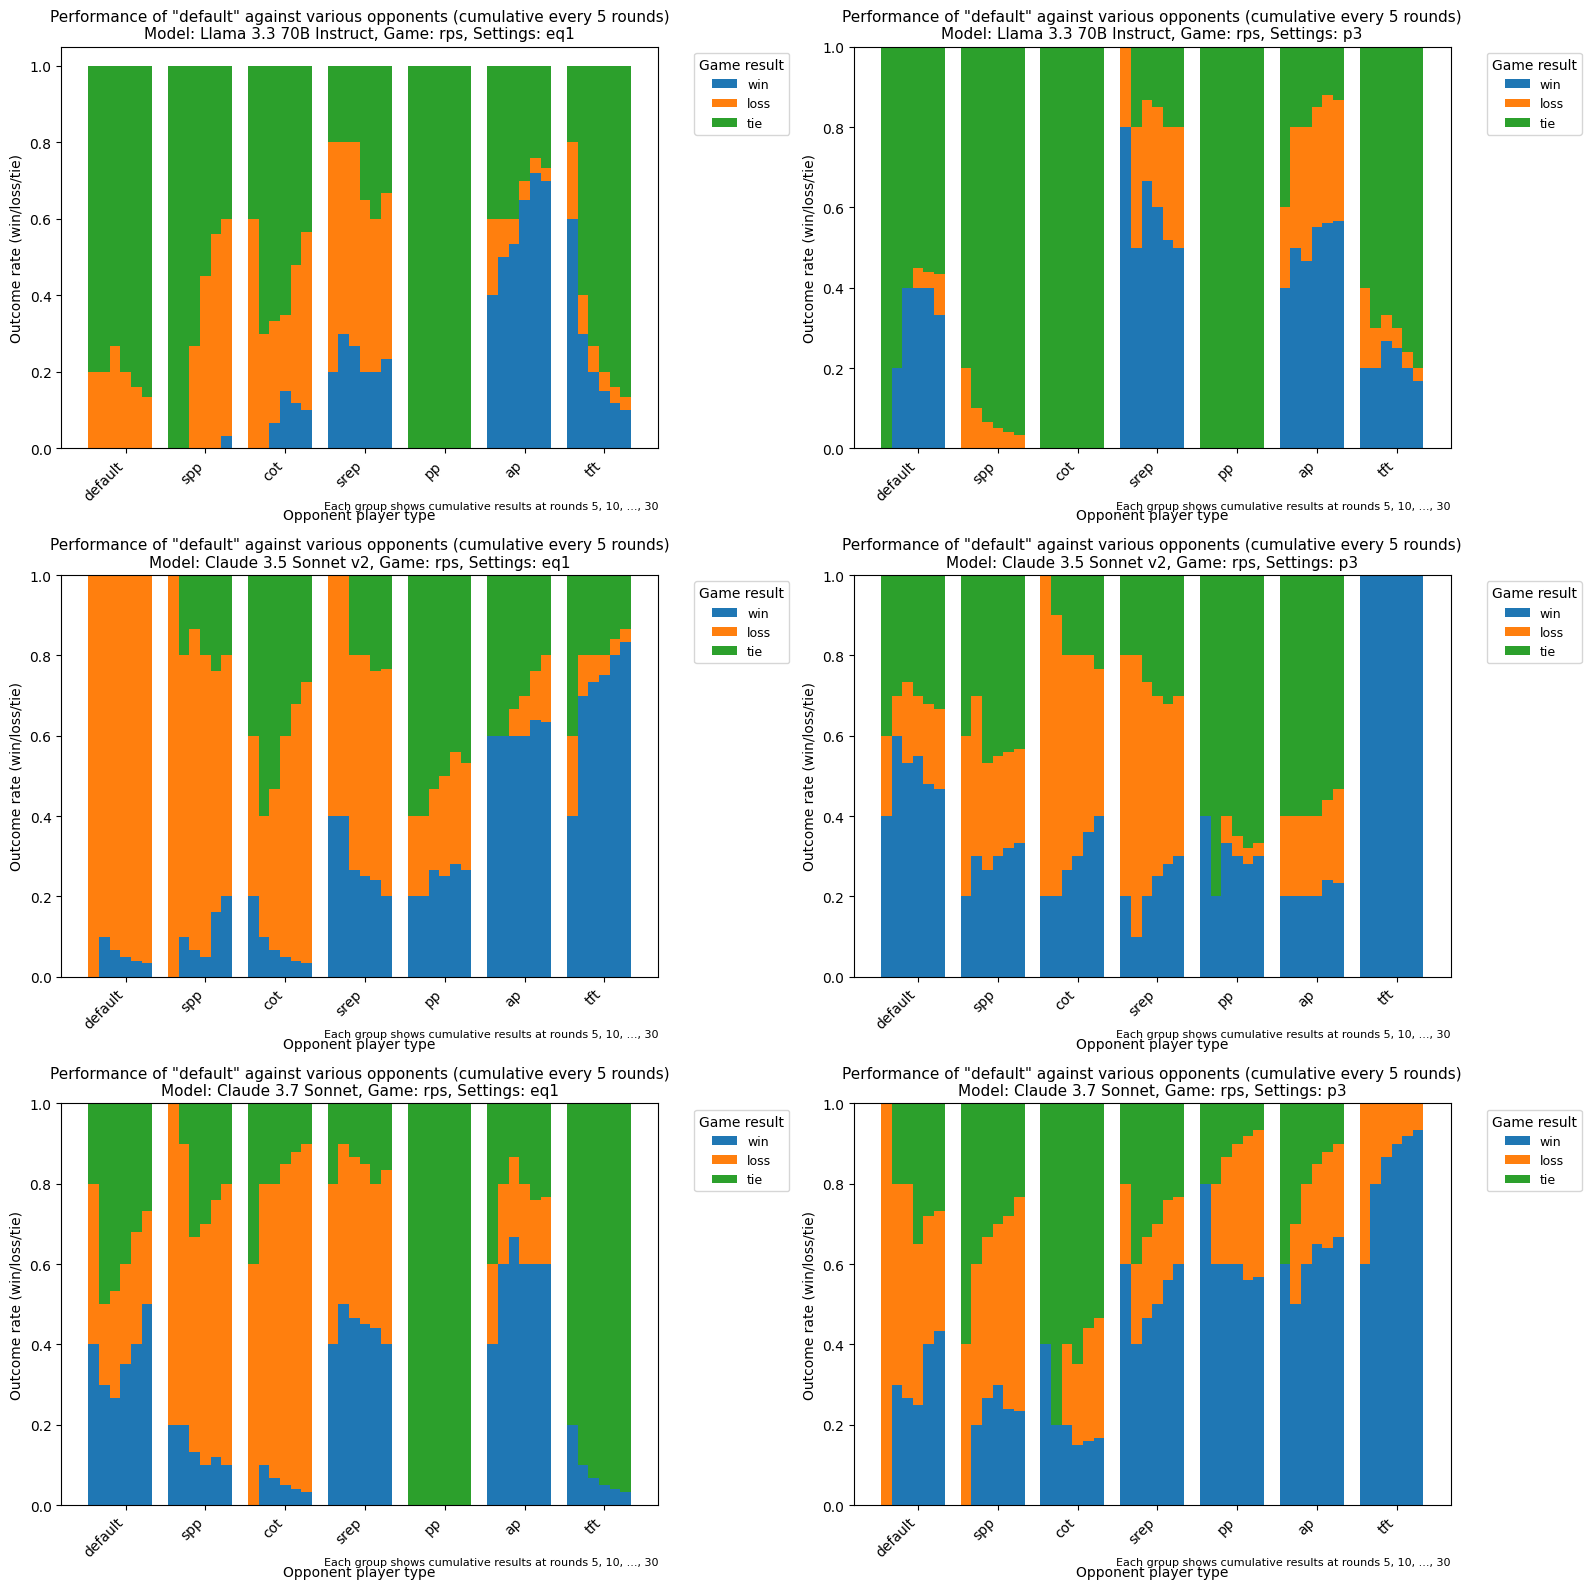

In [12]:
plot_cumulative_results_of_group("default", "data/iteration_1")

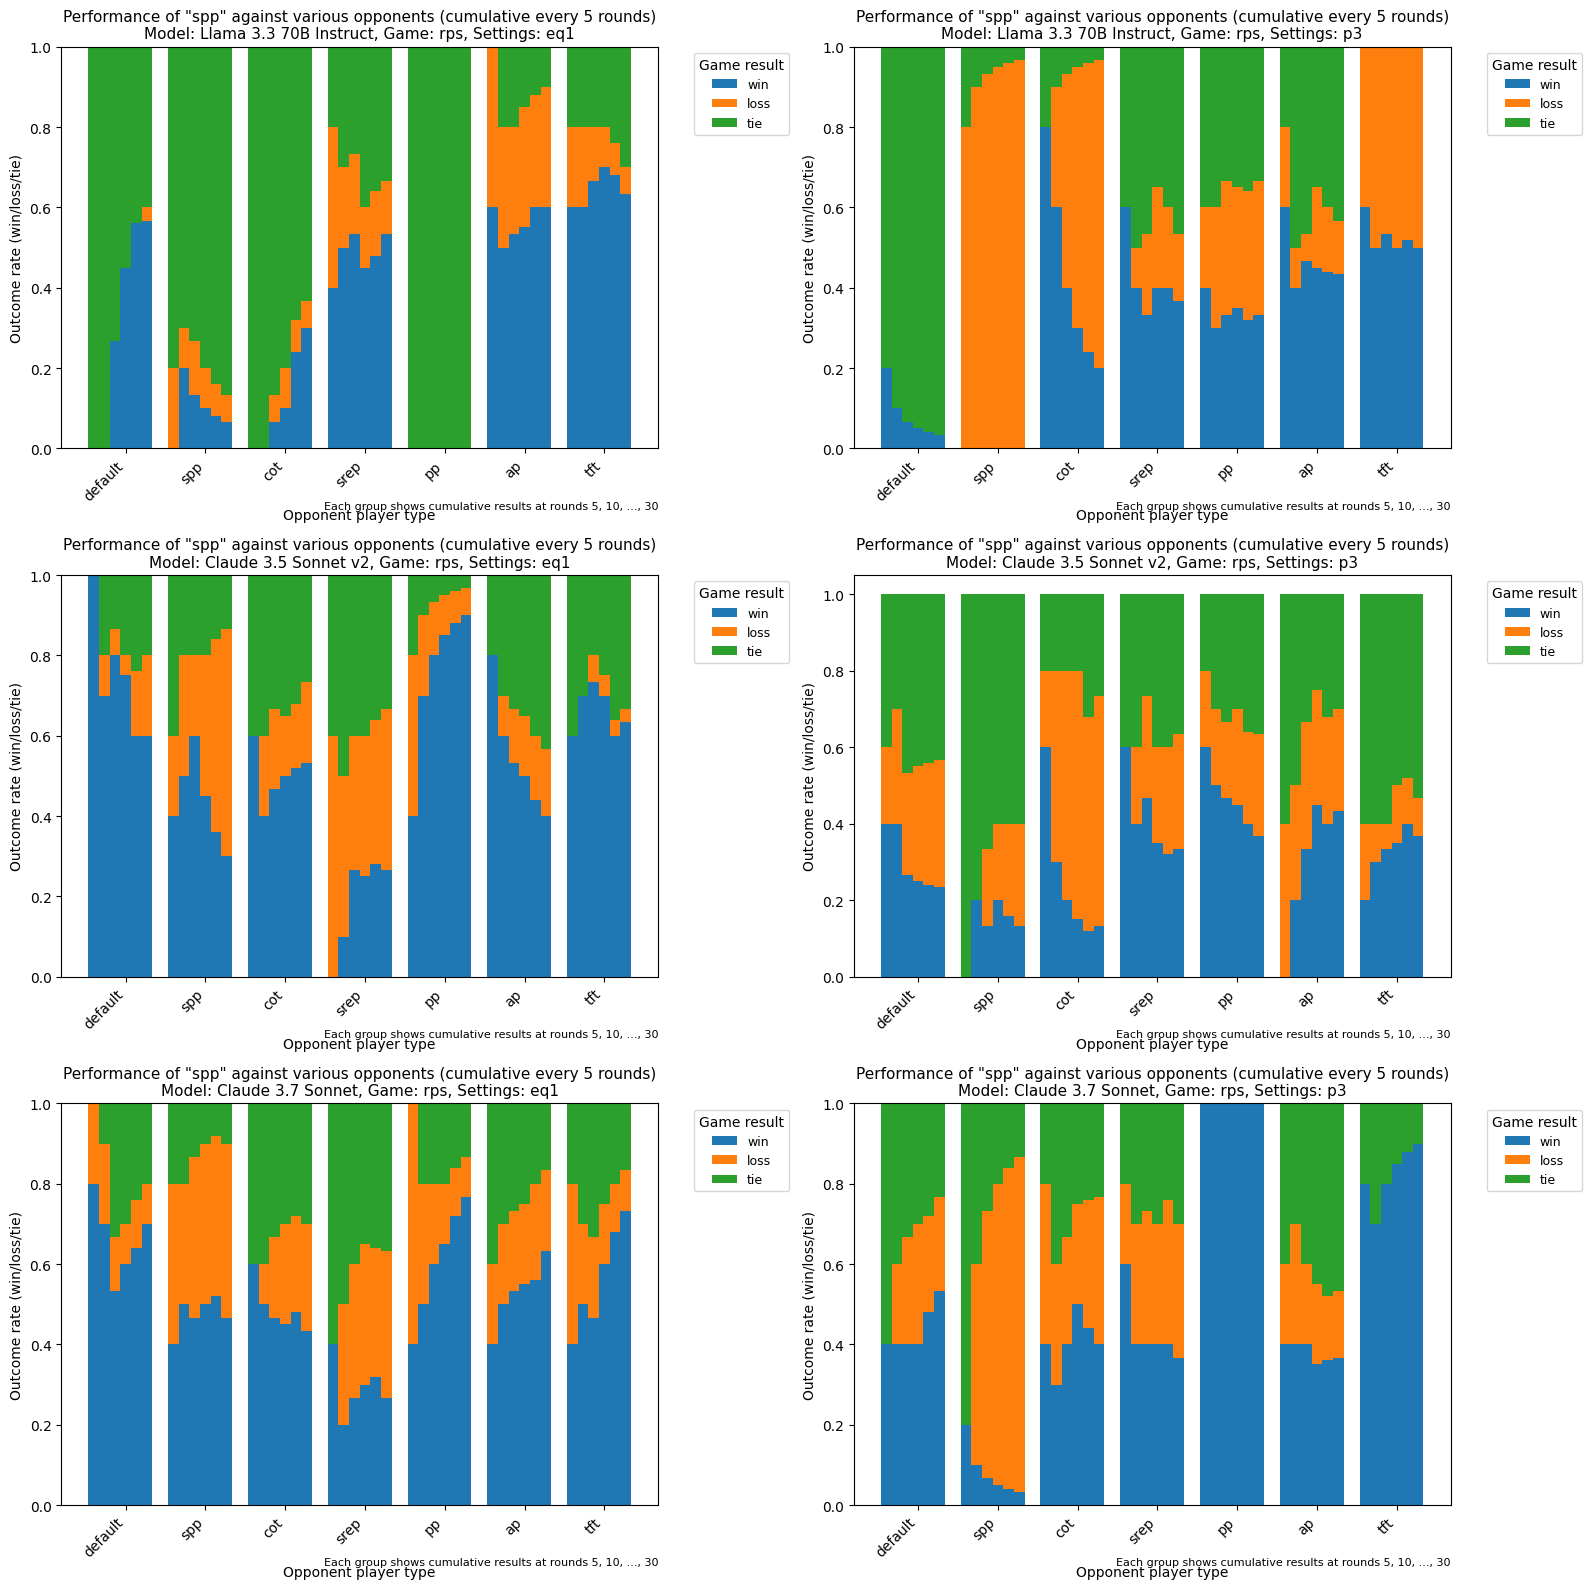

In [13]:
plot_cumulative_results_of_group("spp", "data/iteration_1")

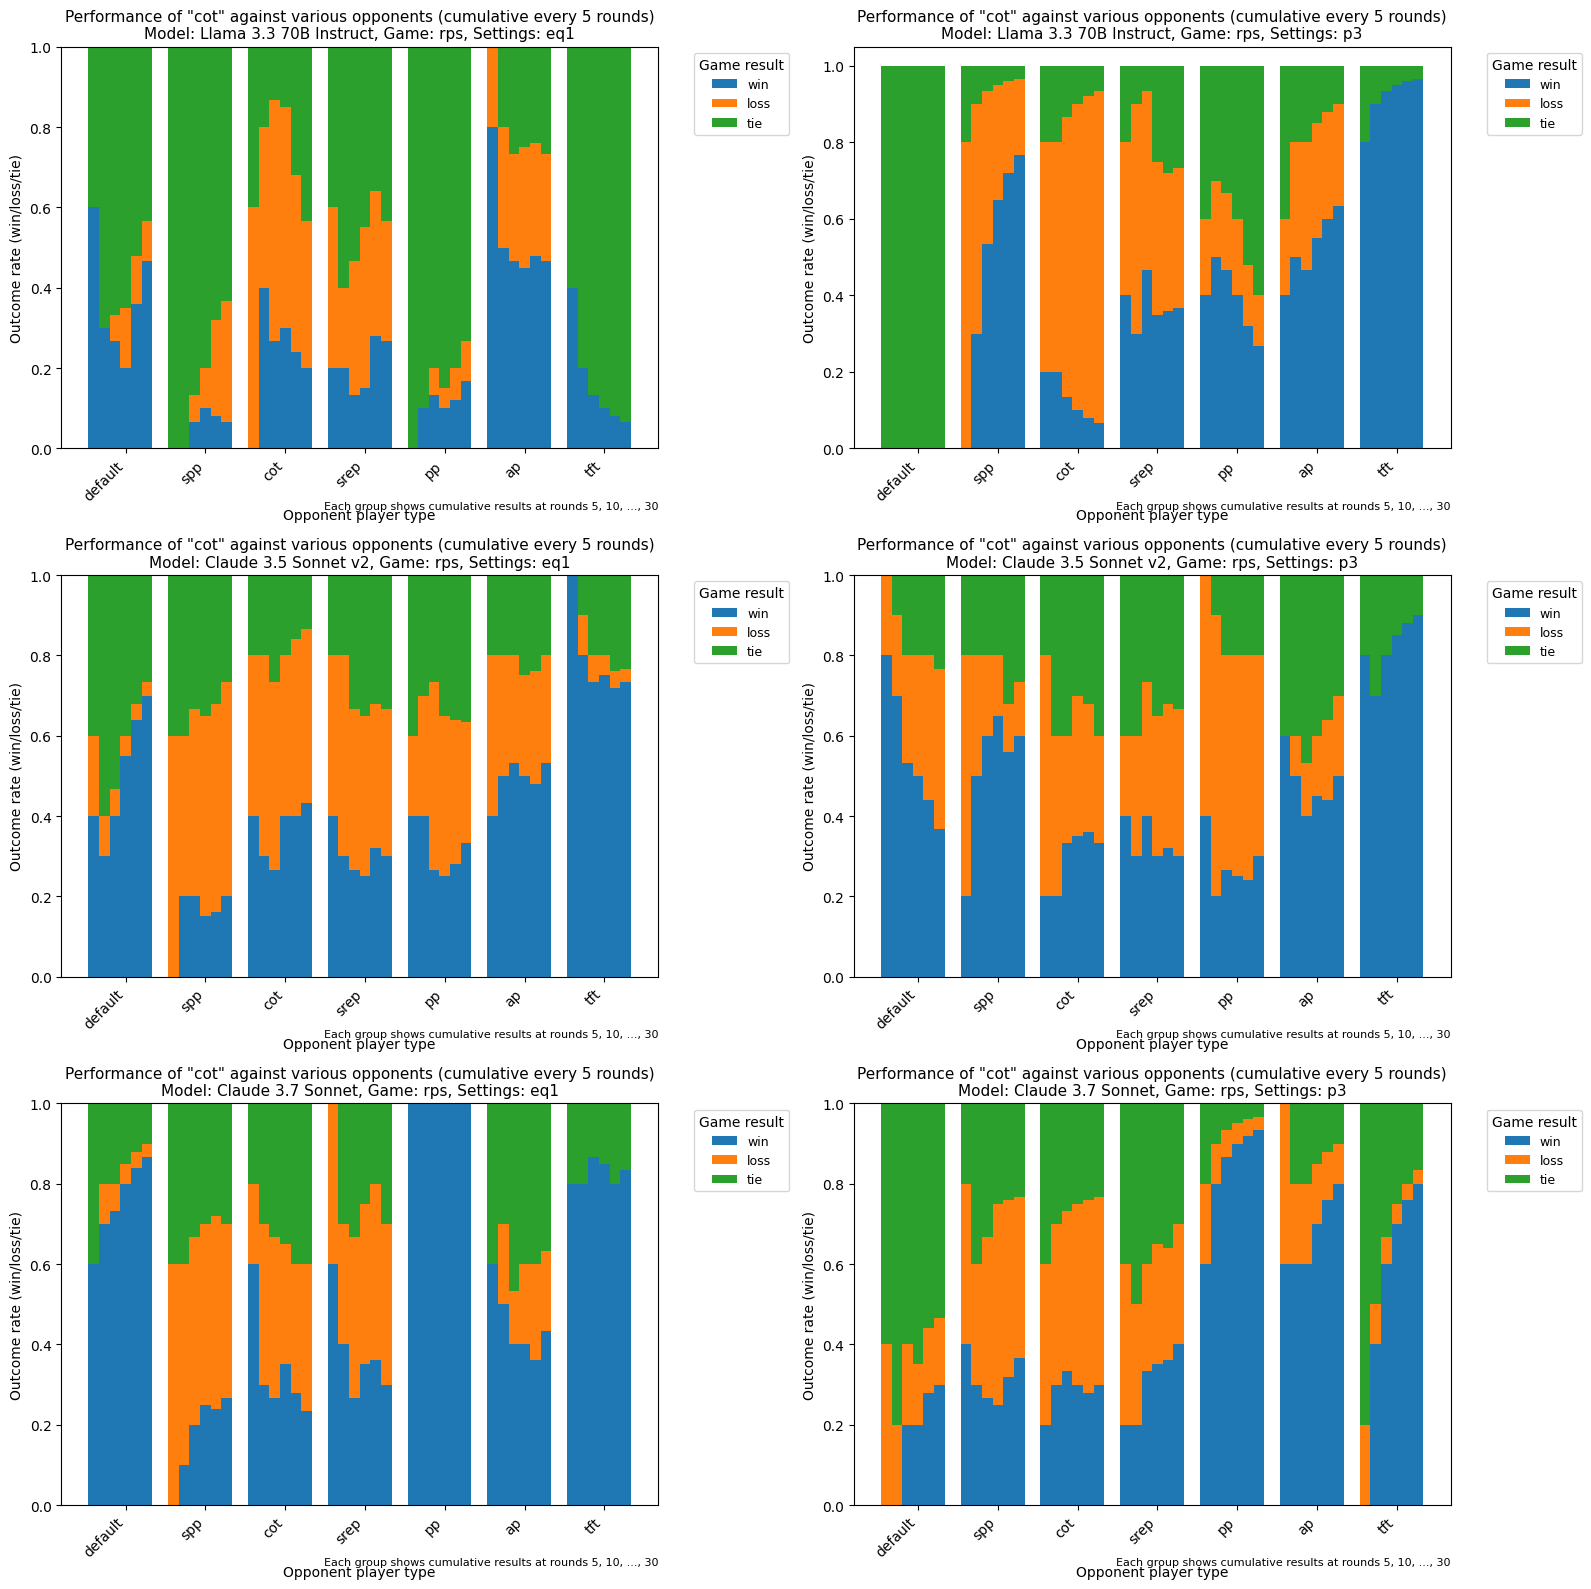

In [14]:
plot_cumulative_results_of_group("cot", "data/iteration_1")

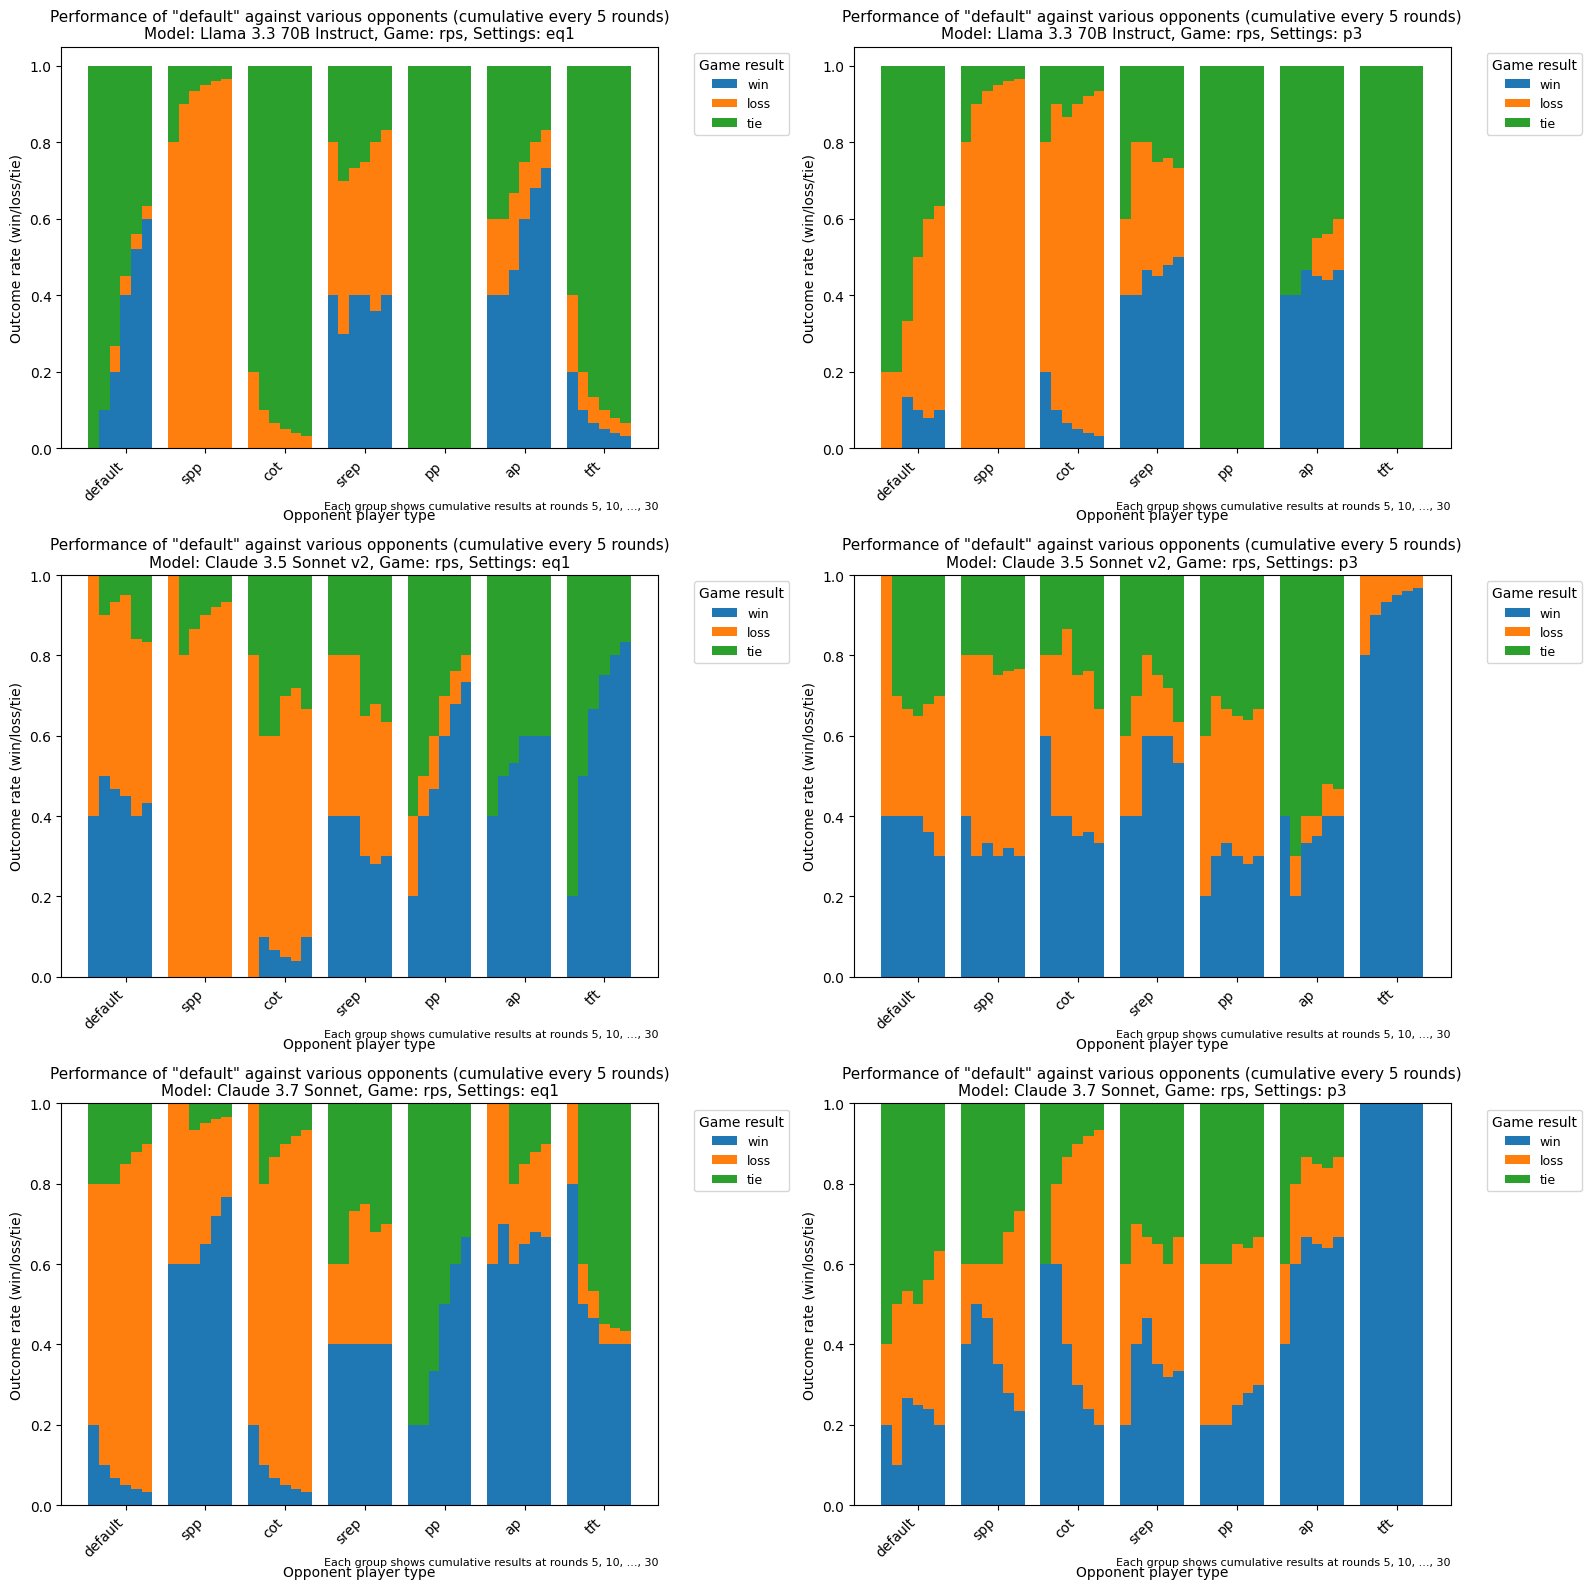

In [15]:
plot_cumulative_results_of_group("default", "data_tot/iteration_1")

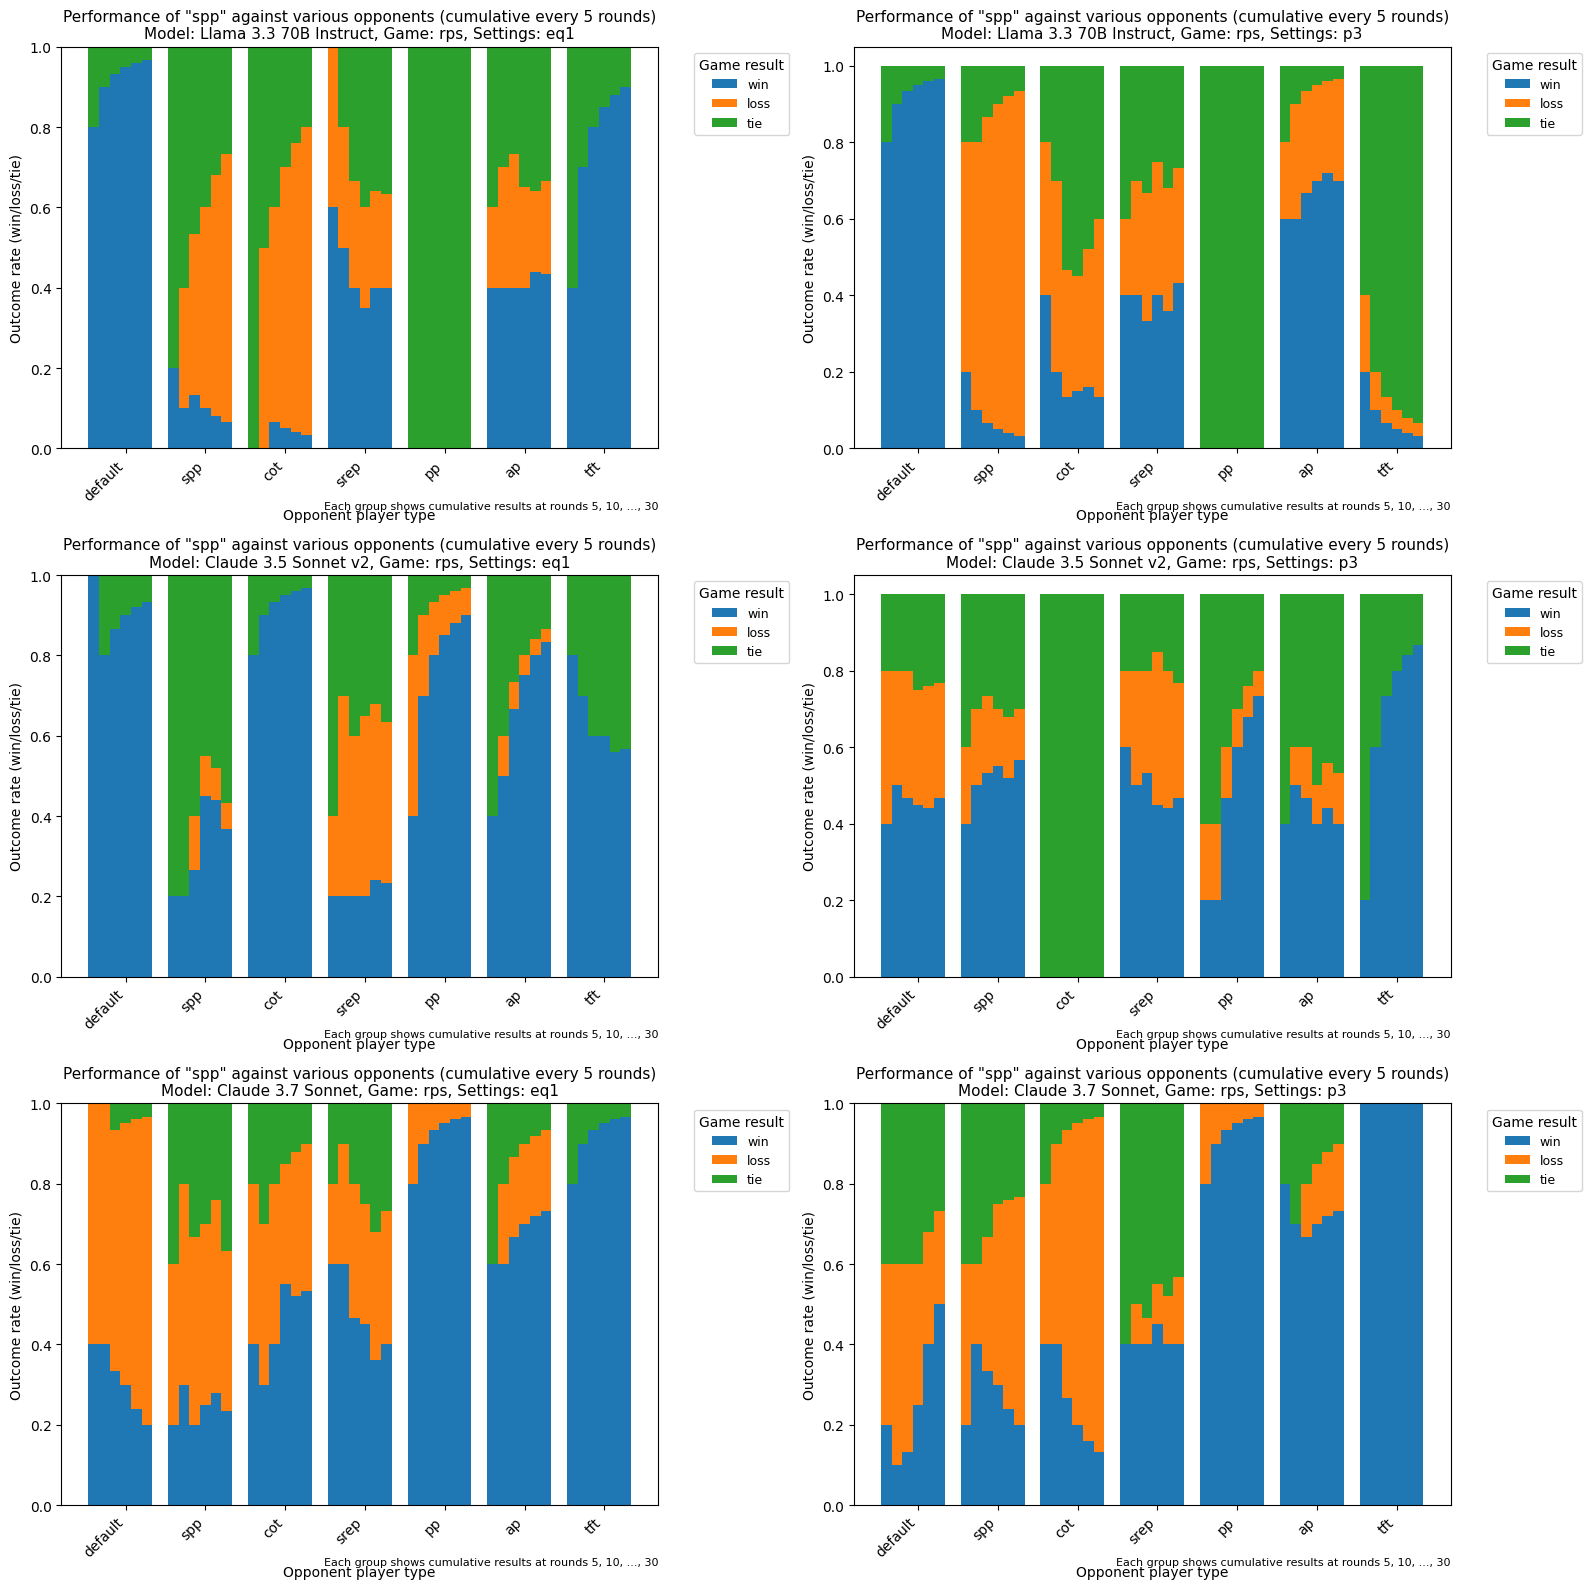

In [16]:
plot_cumulative_results_of_group("spp", "data_tot/iteration_1")

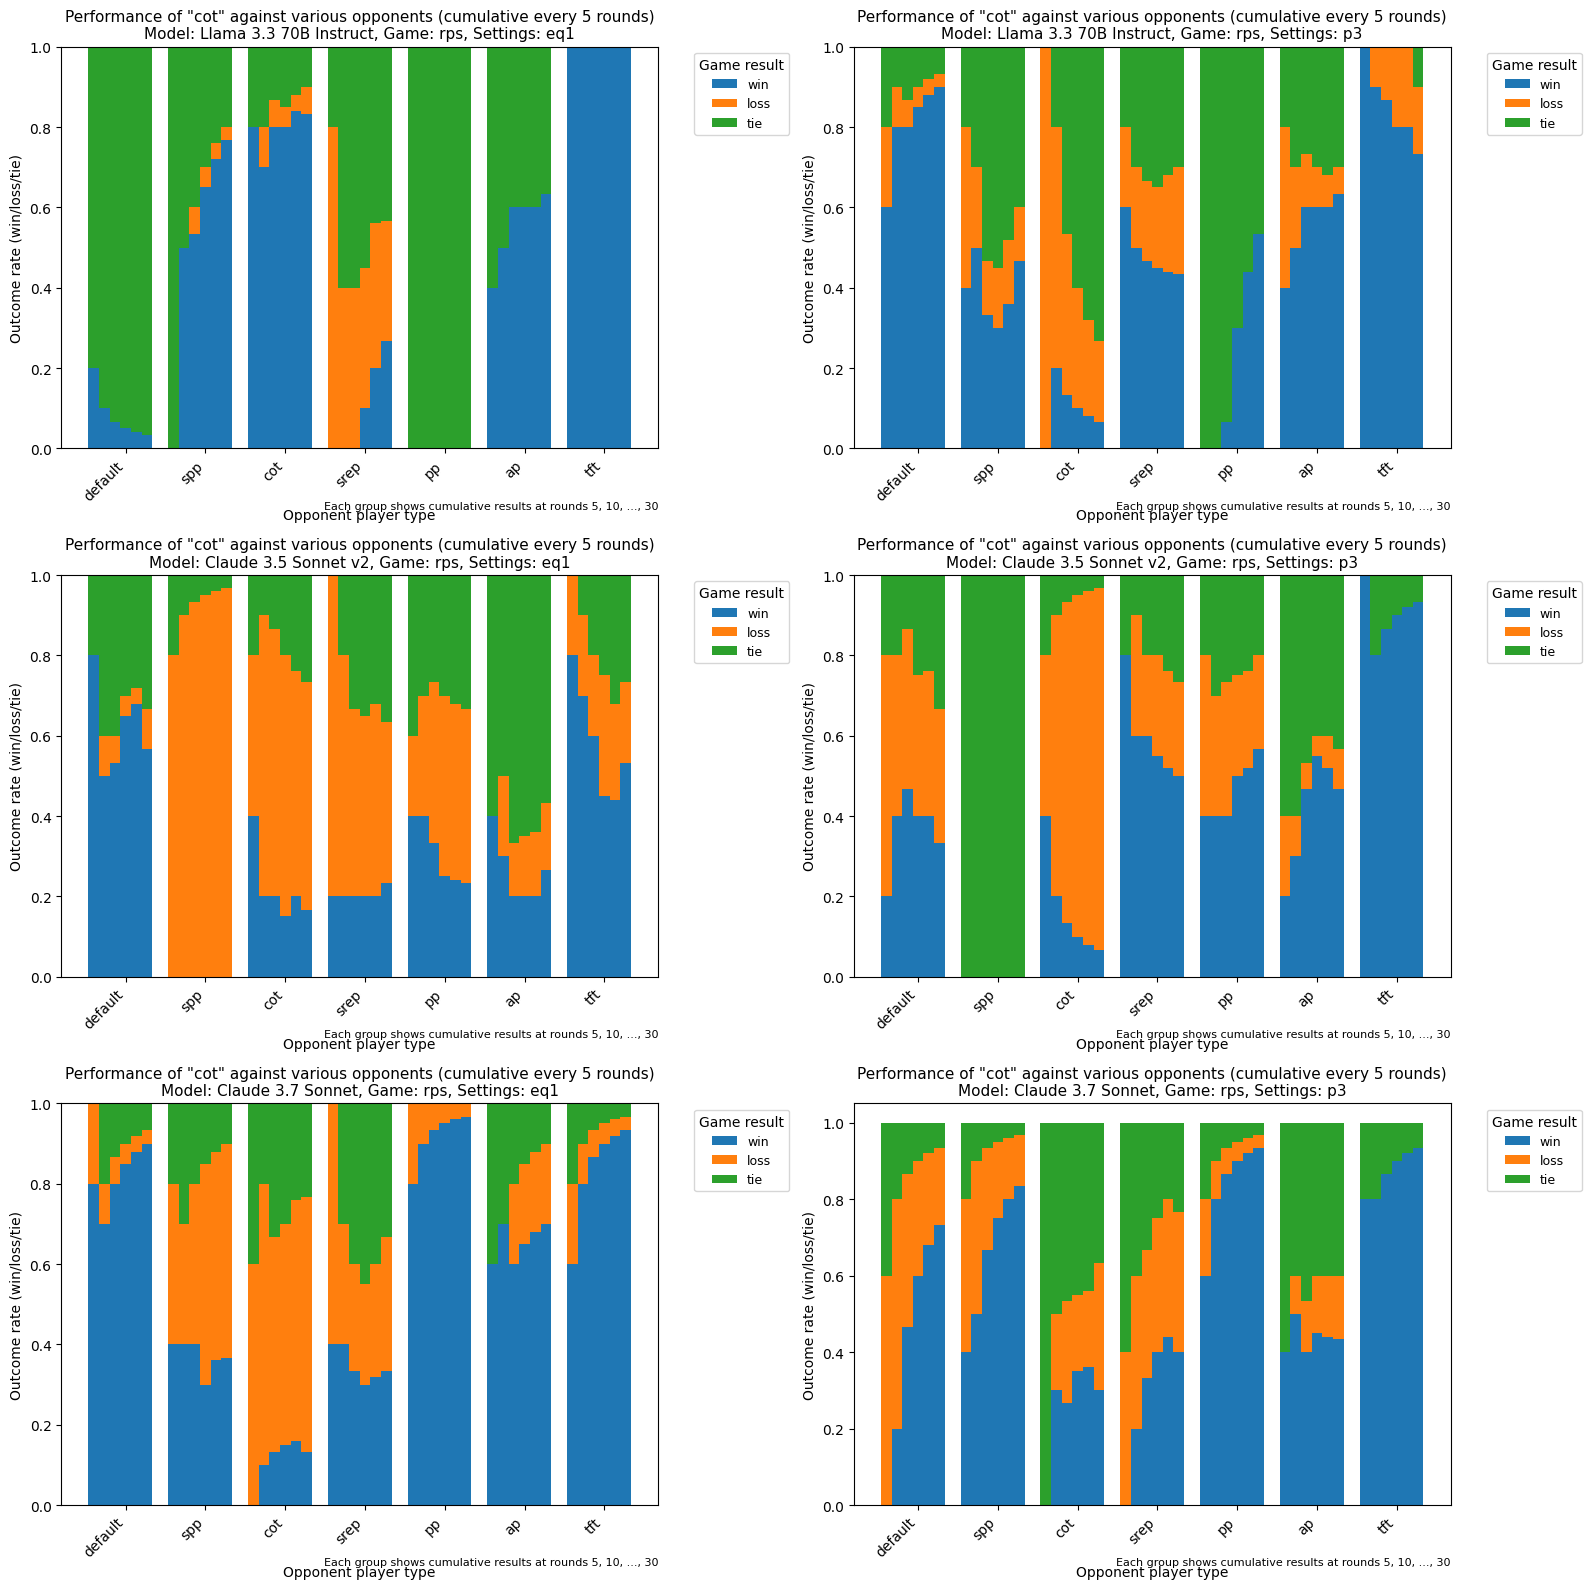

In [17]:
plot_cumulative_results_of_group("cot", "data_tot/iteration_1")